# Work Package 2: Data Preparation

Luca Bühler · Introduction to Data Science WS25/26

**Goal:** Transform the raw dataset into a clean, consistent, and fully model-ready version. 

**Data:** Daily bike rentals (train+test), target = `cnt` (= `casual` + `registered`).


### Notebook Overview

1. Setup and Load Data

2. Missing Values: Seasons

3. Invalid + Missing Values: Humidity

4. Invalid Values: Weekday & Windspeed

5. Feature Cleaning & Reduction


6. Encode categoricals

7. Outlier Strategy

8. Create Final Feature Set


# 1. Setup and Load Data

## Import libraries

In [10]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


## Load and prepare the Bike Rental dataset
This section automatically loads the train/test CSV files, merges them, parses dates, and prints a quick overview of the dataset.

In [11]:
DATA_DIR = os.path.join("..", "data")
train_paths = sorted(glob.glob(os.path.join(DATA_DIR, "BikeRentalDaily_train*.csv")))
test_paths  = sorted(glob.glob(os.path.join(DATA_DIR, "BikeRentalDaily_test*.csv")))

assert train_paths and test_paths, " CSV files not found..."

# Load CSV files
train = pd.read_csv(train_paths[0], sep=";")
test  = pd.read_csv(test_paths[0],  sep=";")

# Add split indicator
train["split"] = "train"
test["split"]  = "test"

# Combine both CSV
df = pd.concat([train, test], ignore_index=True)

# Parse date
df["dteday"] = pd.to_datetime(df["dteday"], format="%d.%m.%Y", errors="coerce")

rows, cols = df.shape
date_min, date_max = df["dteday"].min(), df["dteday"].max()
cnt_ok = ((df["casual"] + df["registered"]) == df["cnt"]).all()

print(f"Shape: {rows} x {cols}")
print(f"Date range: {date_min.date()} to {date_max.date()}")
print(f"Check cnt == casual + registered (all rows): {cnt_ok}")

Shape: 732 x 19
Date range: 2011-01-01 to 2012-12-31
Check cnt == casual + registered (all rows): True


### Baseline Regression

In [12]:
# Linear regression to predict 'cnt' based on other features
feature_cols = ['temp', 'hum', 'windspeed', 'holiday', 'workingday', 'weathersit']
X = df[feature_cols]
y = df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error before Imputation: {mse:.2f}")
print(f"R^2 Score before Imputation: {r2:.2f }")    

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## 2. Missing Values

### 2.1. Quantify missing values

In [13]:


# Count missing values per column
missing_counts = df.isna().sum()

# Percentage of missing values per column
missing_percent = (df.isna().sum() / len(df)) * 100

# Combine into one table for clarity
missing_table = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent.round(2)
})

missing_table


# The table shows that only the 'season' and 'hum' columns have missing values. We will impute these missing values in the next steps.



,missing_count,missing_percent
instant,0,0.00
dteday,0,0.00
season,73,9.97
yr,0,0.00
mnth,0,0.00
holiday,0,0.00
weekday,0,0.00
workingday,0,0.00
weathersit,0,0.00
temp,0,0.00


### 2.2. Check relationships between missing values


In [14]:
# Boolean masks
missing_hum = df['hum'].isna()
missing_season = df['season'].isna()

# Count how many rows have missing humidity AND missing season
overlap_count = (missing_hum & missing_season).sum()

# Show the number
overlap_count


# A overlap of just 2 rows indicates that there isn't any feasible meaningful relationship between the missing values in 'hum' and 'season'.

np.int64(2)

### 2.3. Impute missing values: Season

In [15]:
# Show how each season value is distributed across the months
season_month_table = df.groupby(['season', 'mnth']).size().unstack(fill_value=0)

print(season_month_table)

#Now we can see that the transititons between months take place in the months 3, 6, 9, and 12. 

mnth    1   2   3   4   5   6   7   8   9   10  11  12
season                                                
1.0     55  54  37   0   0   0   0   0   0   0   0  22
2.0      0   0  19  53  56  38   0   0   0   0   0   0
3.0      0   0   0   0   0  17  55  57  39   0   0   0
4.0      0   0   0   0   0   0   0   0  15  58  52  32


In [16]:
 #Show all rows in March
# Show only the columns dateday, instant, mnth, season
march_data = df[df['mnth'] == 3]
march_data_subset = march_data[['dteday', 'instant', 'mnth', 'season']]
pd.set_option('display.max_rows', None)
print(march_data_subset)










   




        dteday  instant  mnth  season
4   2012-03-17      442     3     1.0
51  2012-03-16      441     3     1.0
85  2012-03-22      447     3     2.0
93  2011-03-29       88     3     2.0
94  2011-03-24       83     3     2.0
110 2012-03-14      439     3     1.0
137 2011-03-06       65     3     1.0
144 2011-03-08       67     3     1.0
146 2011-03-12       71     3     1.0
152 2011-03-07       66     3     1.0
165 2012-03-08      433     3     1.0
174 2012-03-03      428     3     1.0
185 2012-03-15      440     3     NaN
188 2011-03-11       70     3     1.0
200 2012-03-30      455     3     2.0
209 2012-03-02      427     3     1.0
220 2012-03-12      437     3     1.0
226 2012-03-10      435     3     1.0
243 2011-03-04       63     3     1.0
248 2011-03-28       87     3     NaN
284 2012-03-31      456     3     2.0
288 2011-03-01       60     3     1.0
293 2012-03-07      432     3     NaN
297 2011-03-25       84     3     2.0
312 2011-03-16       75     3     1.0
316 2012-03-

In [17]:
 #Show all rows in June
# Show only the columns dateday, instant, mnth, season
june_data = df[df['mnth'] == 6]
june_data_subset = june_data[['dteday', 'instant', 'mnth', 'season']]
pd.set_option('display.max_rows', None)
print(june_data_subset)


        dteday  instant  mnth  season
0   2011-06-03      154     6     2.0
10  2011-06-24      175     6     3.0
12  2012-06-16      533     6     2.0
24  2012-06-07      524     6     2.0
53  2011-06-12      163     6     2.0
56  2012-06-12      529     6     2.0
78  2011-06-11      162     6     2.0
100 2012-06-24      541     6     3.0
102 2011-06-06      157     6     2.0
104 2011-06-10      161     6     2.0
106 2011-06-28      179     6     3.0
112 2012-06-28      545     6     3.0
116 2012-06-23      540     6     3.0
196 2011-06-18      169     6     2.0
208 2012-06-02      519     6     2.0
224 2012-06-09      526     6     2.0
244 2012-06-25      542     6     3.0
246 2011-06-16      167     6     2.0
253 2012-06-01      518     6     NaN
272 2011-06-19      170     6     2.0
274 2011-06-04      155     6     2.0
277 2011-06-17      168     6     2.0
287 2011-06-20      171     6     2.0
289 2011-06-07      158     6     2.0
294 2011-06-27      178     6     3.0
300 2011-06-

In [18]:
#Show all rows in September
# Show only the columns dateday, instant, mnth, season
september_data = df[df['mnth'] == 9]
september_data_subset = september_data[['dteday', 'instant', 'mnth', 'season']]
pd.set_option('display.max_rows', None)
print(september_data_subset)

        dteday  instant  mnth  season
5   2011-09-14      257     9     3.0
15  2011-09-26      269     9     NaN
37  2012-09-28      637     9     4.0
39  2011-09-18      261     9     3.0
40  2012-09-17      626     9     3.0
72  2012-09-11      620     9     NaN
89  2011-09-05      248     9     3.0
98  2012-09-06      615     9     NaN
124 2011-09-11      254     9     3.0
127 2012-09-30      639     9     4.0
130 2012-09-10      619     9     3.0
131 2011-09-09      252     9     3.0
141 2011-09-12      255     9     3.0
159 2011-09-10      253     9     3.0
162 2011-09-29      272     9     4.0
164 2011-09-24      267     9     4.0
203 2011-09-17      260     9     3.0
225 2011-09-08      251     9     3.0
239 2011-09-23      266     9     4.0
240 2012-09-18      627     9     3.0
242 2012-09-03      612     9     3.0
245 2012-09-27      636     9     4.0
247 2011-09-16      259     9     3.0
257 2011-09-25      268     9     4.0
270 2012-09-23      632     9     4.0
298 2012-09-

In [19]:
#Show all rows in December
# Show only the columns dateday, instant, mnth, season
december_data = df[df['mnth'] == 12]
december_data_subset = december_data[['dteday', 'instant', 'mnth', 'season']]
pd.set_option('display.max_rows', None)
print(december_data_subset)

        dteday  instant  mnth  season
28  2012-12-22      722    12     1.0
44  2011-12-20      354    12     4.0
60  2012-12-02      702    12     4.0
65  2011-12-07      341    12     4.0
80  2011-12-19      353    12     4.0
81  2012-12-26      726    12     1.0
86  2011-12-05      339    12     NaN
99  2012-12-12      712    12     4.0
107 2012-12-16      716    12     NaN
121 2011-12-25      359    12     1.0
123 2011-12-28      362    12     1.0
133 2011-12-23      357    12     1.0
135 2011-12-27      361    12     1.0
149 2012-12-21      721    12     1.0
153 2012-12-25      725    12     1.0
157 2011-12-08      342    12     4.0
158 2012-12-13      713    12     NaN
166 2011-12-24      358    12     1.0
168 2011-12-29      363    12     1.0
223 2011-12-09      343    12     4.0
230 2012-12-08      708    12     4.0
233 2011-12-26      360    12     1.0
250 2012-12-01      701    12     NaN
251 2011-12-03      337    12     4.0
260 2012-12-24      724    12     1.0
267 2012-12-

In [20]:
# We use the following rule-based encoding :
# Rule based imputation using dteday: 
#1 = Winter (Dec. 21–Mar. 20)
#2 = Spring (Mar. 21–Jun. 20)
#3 = Summer (Jun. 21–Sept. 22)
#4 = Fall (Sept. 23–Dec. 20)

df['dteday'] = pd.to_datetime(df['dteday'], dayfirst=True)

# Function to determine season from date
def season_from_date(date):
    month = date.month
    day = date.day

    # Winter: Dec 21 – Mar 20
    if (month == 12 and day >= 21) or (month in [1, 2]) or (month == 3 and day <= 20):
        return 1

    # Spring: Mar 21 – Jun 20
    elif (month == 3 and day >= 21) or (month in [4, 5]) or (month == 6 and day <= 20):
        return 2

    # Summer: Jun 21 – Sep 22
    elif (month == 6 and day >= 21) or (month in [7, 8]) or (month == 9 and day <= 22):
        return 3

    # Fall: Sep 23 – Dec 20
    else:
        return 4

missing_season_mask = df['season'].isna()

df.loc[missing_season_mask, 'season'] = (
    df.loc[missing_season_mask, 'dteday']
      .apply(season_from_date)
)


print("Remaining missing seasons:", df['season'].isna().sum())



Remaining missing seasons: 0


In [21]:
# Print sample of all rows in december
december_data = df[df['mnth'] == 12]
december_data_subset = december_data[['dteday', 'mnth', 'season']]
pd.set_option('display.max_rows', None)
print(december_data_subset)




        dteday  mnth  season
28  2012-12-22    12     1.0
44  2011-12-20    12     4.0
60  2012-12-02    12     4.0
65  2011-12-07    12     4.0
80  2011-12-19    12     4.0
81  2012-12-26    12     1.0
86  2011-12-05    12     4.0
99  2012-12-12    12     4.0
107 2012-12-16    12     4.0
121 2011-12-25    12     1.0
123 2011-12-28    12     1.0
133 2011-12-23    12     1.0
135 2011-12-27    12     1.0
149 2012-12-21    12     1.0
153 2012-12-25    12     1.0
157 2011-12-08    12     4.0
158 2012-12-13    12     4.0
166 2011-12-24    12     1.0
168 2011-12-29    12     1.0
223 2011-12-09    12     4.0
230 2012-12-08    12     4.0
233 2011-12-26    12     1.0
250 2012-12-01    12     4.0
251 2011-12-03    12     4.0
260 2012-12-24    12     1.0
267 2012-12-23    12     1.0
286 2011-12-21    12     1.0
292 2012-12-31    12     1.0
299 2012-12-28    12     1.0
351 2012-12-10    12     4.0
363 2012-12-27    12     1.0
383 2011-12-06    12     4.0
417 2011-12-17    12     4.0
419 2011-12-11

## 3. Invalid + Missing Values: Humidity


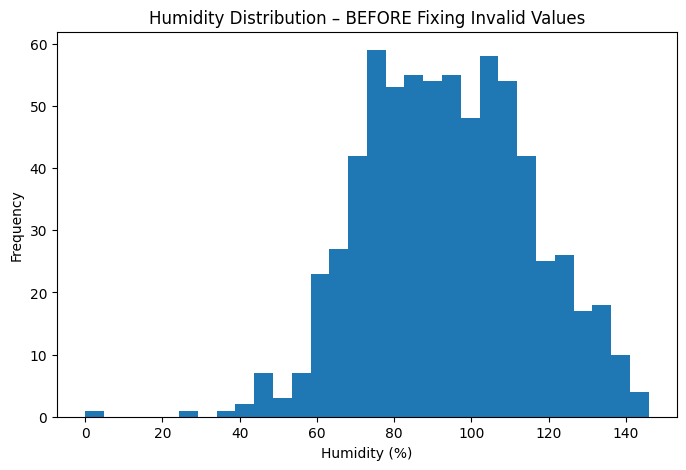

In [22]:
# Find invalid humidity values
invalid_hum = df['hum'] > 100
invalid_hum.sum()


# Show histogram before fixing invalid values
plt.figure(figsize=(8, 5))
plt.hist(df['hum'], bins=30)
plt.title("Humidity Distribution – BEFORE Fixing Invalid Values")
plt.xlabel("Humidity (%)")
plt.ylabel("Frequency")
plt.show()







In [23]:
# find missing values
missing_hum = df['hum'].isna()
missing_hum.sum()

np.int64(40)

### Fixing the scale of humidty 

Min scaled humidity: 0.0
Max scaled humidity: 100.0
Missing humidity: 40


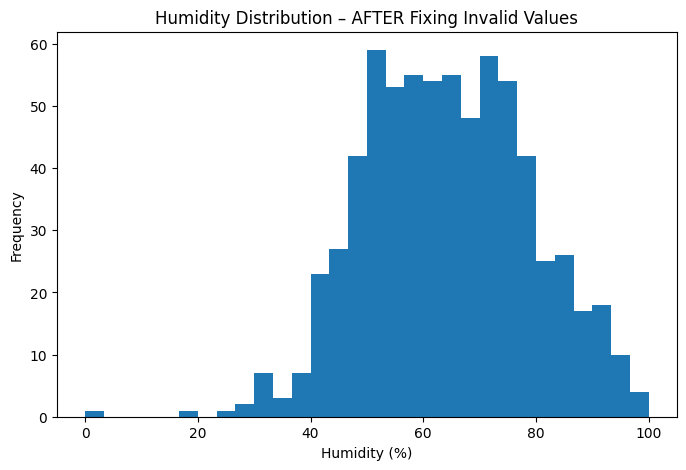

In [24]:


# Scale to 0-100
scaler = MinMaxScaler(feature_range=(0, 100))
df['hum_scaled'] = scaler.fit_transform(df[['hum']])

# Check results
print("Min scaled humidity:", df['hum_scaled'].min())
print("Max scaled humidity:", df['hum_scaled'].max())
print("Missing humidity:", df['hum_scaled'].isna().sum())


# Histogram after fixing invalid values
plt.figure(figsize=(8, 5))
plt.hist(df['hum_scaled'], bins=30)
plt.title("Humidity Distribution – AFTER Fixing Invalid Values")
plt.xlabel("Humidity (%)")
plt.ylabel("Frequency")
plt.show()

### Impute missing values 

In [25]:
# Use group-based imputation by weathersit
# Make copy of scaled humidity
df['hum_scaled_before_impute'] = df['hum_scaled']   

# Compute weathersit median humidity
weathersit_median_hum = df.groupby('weathersit')['hum_scaled'].median()
print(weathersit_median_hum)
# Impute missing values
for weathersit, median_value in weathersit_median_hum.items():
    mask = (df['weathersit'] == weathersit) & (df['hum_scaled'].isna())
    df.loc[mask, 'hum_scaled'] = median_value   
# Check results
print("Min scaled humidity:", df['hum_scaled'].min())
print("Max scaled humidity:", df['hum_scaled'].max())
print("Missing humidity:", df['hum_scaled'].isna().sum())


weathersit
1    57.797738
2    75.492751
3    91.274550
Name: hum_scaled, dtype: float64
Min scaled humidity: 0.0
Max scaled humidity: 100.0
Missing humidity: 0


### Visualisation of humidity after new scaling and imputation of missing value

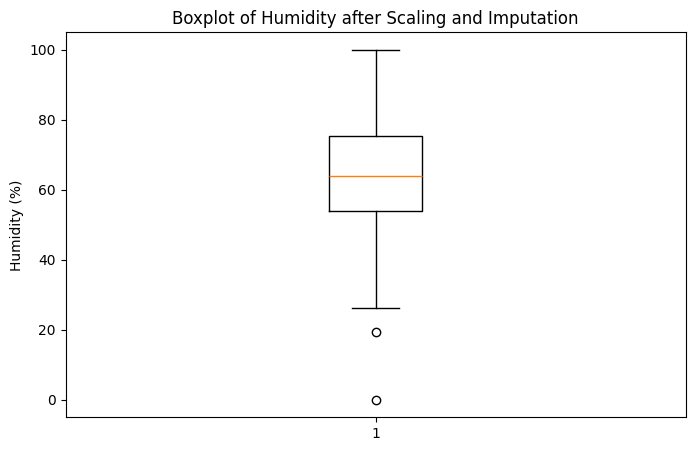

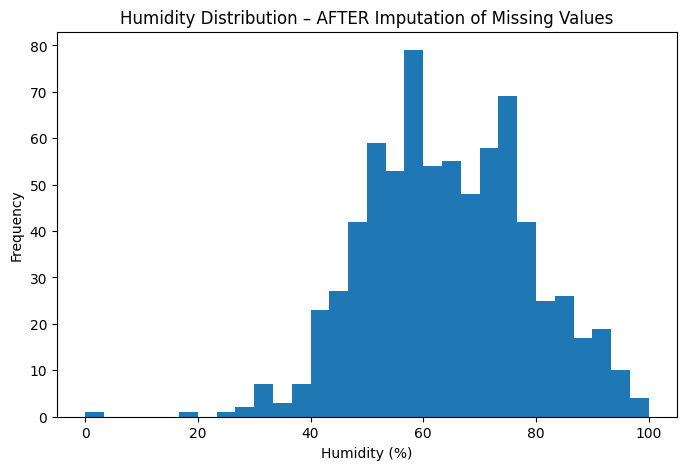

In [26]:
#Boxplot of humidity after new scaling and imputation of missing value
plt.figure(figsize=(8, 5))
plt.boxplot(df['hum_scaled'].dropna(), vert=True)
plt.title("Boxplot of Humidity after Scaling and Imputation")
plt.ylabel("Humidity (%)")
plt.show()  


#Histogram after fixing invalid values and imputing missing values
plt.figure(figsize=(8, 5))
plt.hist(df['hum_scaled'], bins=30)
plt.title("Humidity Distribution – AFTER Imputation of Missing Values")
plt.xlabel("Humidity (%)")
plt.ylabel("Frequency")
plt.show()

### Linear regression after fixing incorrect and missing values in humidity

In [27]:
#inear Regression after fixing missing values in humidity

feature_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 
                'weathersit', 'temp', 'atemp', 'hum_scaled']
X = df[feature_cols]
y = df['cnt']   
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  
# Split back into train and test sets
X_train = X_scaled[df['split'] == 'train']
y_train = y[df['split'] == 'train']
X_test  = X_scaled[df['split'] == 'test']
y_test  = y[df['split'] == 'test']
# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)
# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error after Humidity Imputation: {mse:.2f}")
print(f"R^2 Score after Humidity Imputation: {r2:.2f}") 

Mean Squared Error after Humidity Imputation: 5747738.98
R^2 Score after Humidity Imputation: 0.40


## 4. Invalid Values: Weekday & Windspeed

### 4.1. Invalid values: Weekday

In [28]:
# Ensure date column is in datetime format
df['dteday'] = pd.to_datetime(df['dteday'], dayfirst=True)

# Identify invalid weekday values
invalid_weekday_mask = ~df['weekday'].isin(range(0, 7))

# Count invalid weekday values
invalid_weekday_mask.sum()

# Impute invalid weekday values based on dteday
df.loc[invalid_weekday_mask, 'weekday'] = df.loc[invalid_weekday_mask, 'dteday'].dt.weekday

# Final check for invalid weekday values
print("Invalid weekday values remaining:", (~df['weekday'].isin(range(0,7))).sum())









Invalid weekday values remaining: 0


### 4.2. Invalid values: Windspeed

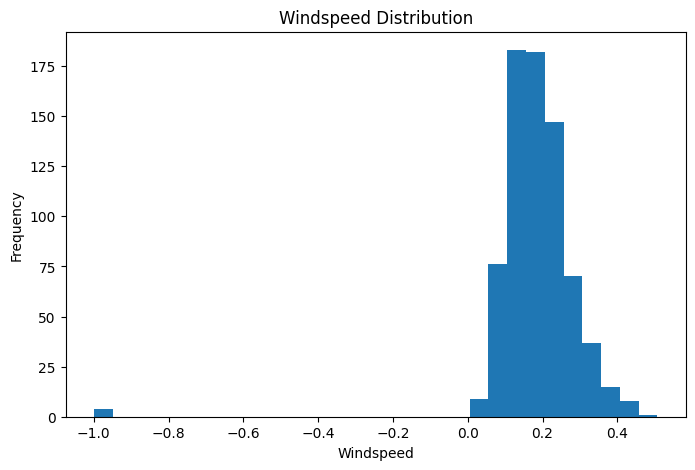

In [29]:
# Display the right skewed distribution of windspeed
plt.figure(figsize=(8, 5))
plt.hist(df['windspeed'], bins=30)
plt.title("Windspeed Distribution")
plt.xlabel("Windspeed")
plt.ylabel("Frequency")
plt.show()

In [30]:
# Identify invalid windspeed values
invalid_wind_mask = (df['windspeed'] == -1)
invalid_wind_mask.sum()

# Compute median of valid windspeed values
valid_wind_median = df.loc[df['windspeed'] != -1, 'windspeed'].median()

# Impute invalid windspeed values with median
df.loc[invalid_wind_mask, 'windspeed'] = valid_wind_median


# Final check for invalid windspeed values
print("Invalid windspeed remaining:", (df['windspeed'] == -1).sum())



Invalid windspeed remaining: 0


### Linear Regression after handling invalid values

In [31]:
# Linear Regression after with newest fixes
feature_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 
                'weathersit', 'temp', 'atemp', 'hum_scaled', 'windspeed']
X = df[feature_cols]
y = df['cnt']   
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  
# Split back into train and test sets
X_train = X_scaled[df['split'] == 'train']
y_train = y[df['split'] == 'train']
X_test  = X_scaled[df['split'] == 'test']
y_test  = y[df['split'] == 'test']
# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)
# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error after All Imputations: {mse:.2f}")
print(f"R^2 Score after All Imputations: {r2: }")
#




Mean Squared Error after All Imputations: 5701755.76
R^2 Score after All Imputations:  0.4093121348612202


## 5. Feature removal

In [32]:
print(df.columns)


Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'leaflets', 'price reduction', 'casual', 'registered', 'cnt', 'split',
       'hum_scaled', 'hum_scaled_before_impute'],
      dtype='object')


In [33]:
# Drop reduntant features 'atemp' and 'instant'
#df = df.drop(columns=['atemp', 'instant'], errors='ignore')



# Final shape of the cleaned dataframe
df.shape

(732, 21)

## 6. Encode categoricals

### Cyclical Encoding 

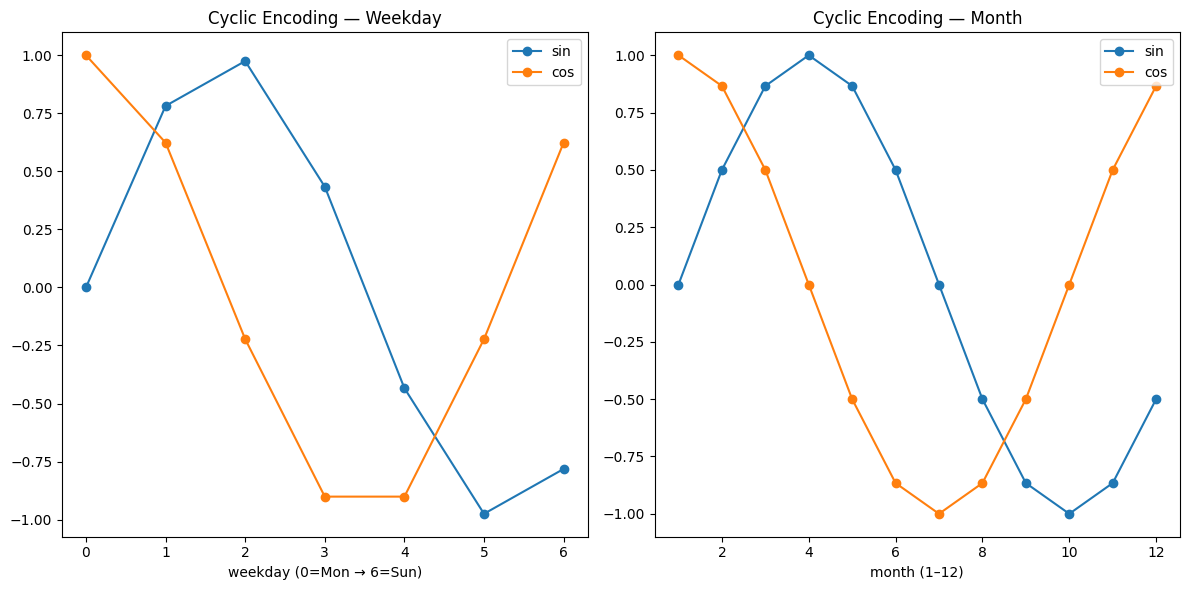

In [34]:

# Ensure categorical types
df['weekday'] = df['weekday'].astype('category')
df['mnth'] = df['mnth'].astype('category')

# Convert to numeric codes
df['weekday_num'] = df['weekday'].cat.codes  # 0–6
df['mnth_num']    = df['mnth'].cat.codes + 1 # 1–12

# Cyclic Encoding of weekday, month and season
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday_num'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday_num'] / 7)

df['mnth_sin'] = np.sin(2 * np.pi * df['mnth_num'] / 12)
df['mnth_cos'] = np.cos(2 * np.pi * df['mnth_num'] / 12)



# ---- Visualisation: one full cycle instead of time series ----
unique_weekdays = np.arange(7)
unique_months = np.arange(1, 13)
unique_seasons = np.arange(1, 5)

# Create sine/cosine for clean visualization
weekday_sin_cycle = np.sin(2 * np.pi * unique_weekdays / 7)
weekday_cos_cycle = np.cos(2 * np.pi * unique_weekdays / 7)
month_sin_cycle   = np.sin(2 * np.pi * (unique_months-1) / 12)
month_cos_cycle   = np.cos(2 * np.pi * (unique_months-1) / 12)


plt.figure(figsize=(12, 6))

# Weekday cycle
# Make the scale of weekday from 0-6 longer so it returns to the starting point
plt.subplot(1, 2, 1)
plt.plot(unique_weekdays, weekday_sin_cycle, marker='o', label="sin")
plt.plot(unique_weekdays, weekday_cos_cycle, marker='o', label="cos")

plt.title("Cyclic Encoding — Weekday")
plt.xlabel("weekday (0=Mon → 6=Sun)")
plt.legend()    



# Month cycle
plt.subplot(1, 2, 2)
plt.plot(unique_months, month_sin_cycle, marker='o', label="sin")
plt.plot(unique_months, month_cos_cycle, marker='o', label="cos")
plt.title("Cyclic Encoding — Month")
plt.xlabel("month (1–12)")
plt.legend()


plt.tight_layout()
plt.show()



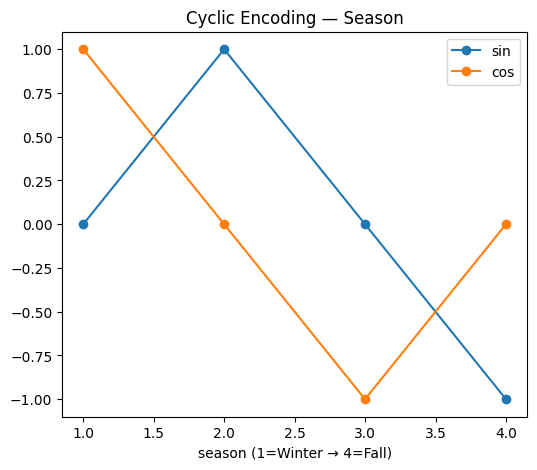

In [35]:
#Encode season cyclically
df['season_sin'] = np.sin(2 * np.pi * df['season'] / 4) 
df['season_cos'] = np.cos(2 * np.pi * df['season'] / 4)

#Visualize season cycle
unique_seasons = np.arange(1, 5)
season_sin_cycle = np.sin(2 * np.pi * (unique_seasons-1) / 4)
season_cos_cycle = np.cos(2 * np.pi * (unique_seasons-1) / 4)
plt.figure(figsize=(6, 5))
plt.plot(unique_seasons, season_sin_cycle, marker='o', label="sin")
plt.plot(unique_seasons, season_cos_cycle, marker='o', label="cos")
plt.title("Cyclic Encoding — Season")
plt.xlabel("season (1=Winter → 4=Fall)")
plt.legend()
plt.show()





In [36]:
# Linear regression after all preprocessing steps

feature_cols = ['season_sin', 'season_cos', 'yr', 'mnth_sin', 'mnth_cos', 'holiday', 'weekday_sin', 
                'weekday_cos', 'workingday', 'weathersit', 'temp', 'hum_scaled', 'windspeed']
X = df[feature_cols]
y = df['cnt']   
 
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

# Split back into train and test sets
X_train = X_scaled[df['split'] == 'train']
y_train = y[df['split'] == 'train']
X_test  = X_scaled[df['split'] == 'test']
y_test  = y[df['split'] == 'test']
# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)
# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error after All Imputations: {mse:.2f}")
print(f"R^2 Score after All Imputations: {r2: }")


Mean Squared Error after All Imputations: 6622519.05
R^2 Score after All Imputations:  0.3139233238748612


### Label Encoding - Weathersit


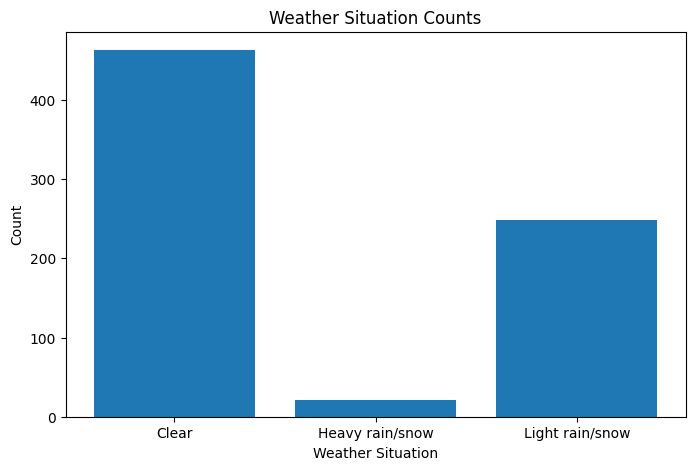

In [37]:
# Create a scale with increasingly worse weather conditions from 1 to 3
weather_labels = {
    1: 'Clear',
    2: 'Light rain/snow',
    3: 'Heavy rain/snow'    
}

df['weathersit_str'] = df['weathersit'].map(weather_labels)

# SHow a diagram on how many instances per weather situation
weather_counts = df['weathersit_str'].value_counts().sort_index()   
plt.figure(figsize=(8, 5))
plt.bar(weather_counts.index, weather_counts.values)
plt.title("Weather Situation Counts")
plt.xlabel("Weather Situation")
plt.ylabel("Count")
plt.show()




### Investigate correlations 

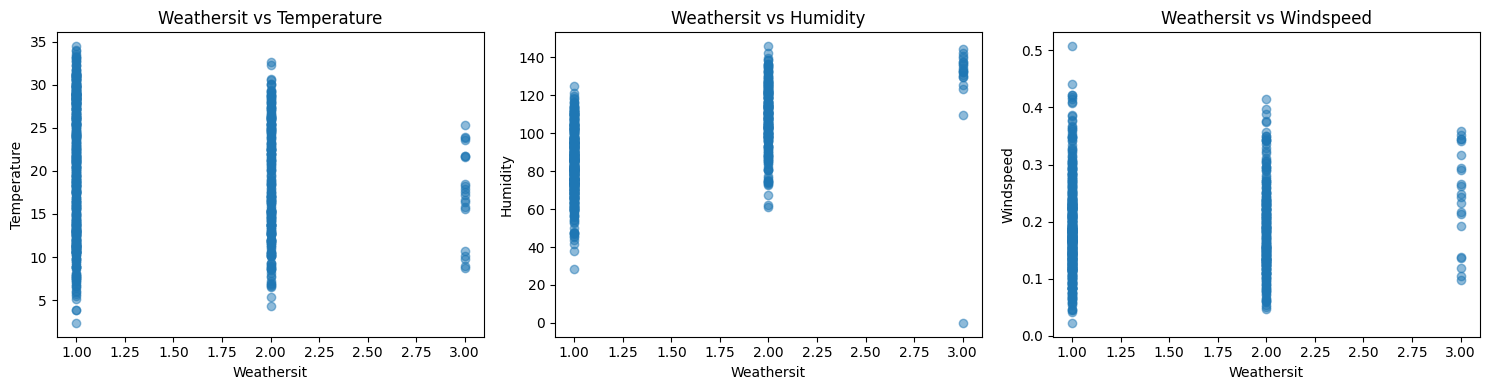

In [38]:
#Investigate correlations between weathersit and temperature/humidity/windspeed
plt.figure(figsize=(15, 4)) 
plt.subplot(1, 3, 1)
plt.scatter(df['weathersit'], df['temp'], alpha=0.5)
plt.title("Weathersit vs Temperature")
plt.xlabel("Weathersit")
plt.ylabel("Temperature")
plt.subplot(1, 3, 2)
plt.scatter(df['weathersit'], df['hum'], alpha=0.5)
plt.title("Weathersit vs Humidity")
plt.xlabel("Weathersit")
plt.ylabel("Humidity")
plt.subplot(1, 3, 3)
plt.scatter(df['weathersit'], df['windspeed'], alpha=0.5)
plt.title("Weathersit vs Windspeed")
plt.xlabel("Weathersit")
plt.ylabel("Windspeed")     
plt.tight_layout()
plt.show()  


## 7. Outlier Handling

In [39]:
# Define peak threshold
peak_threshold = df['cnt'].quantile(0.95)

# Flag peak days
df['is_peak'] = df['cnt'] >= peak_threshold

print("Peak threshold:", peak_threshold)
print(df['is_peak'].value_counts())


Peak threshold: 7575.599999999999
is_peak
False    695
True      37
Name: count, dtype: int64


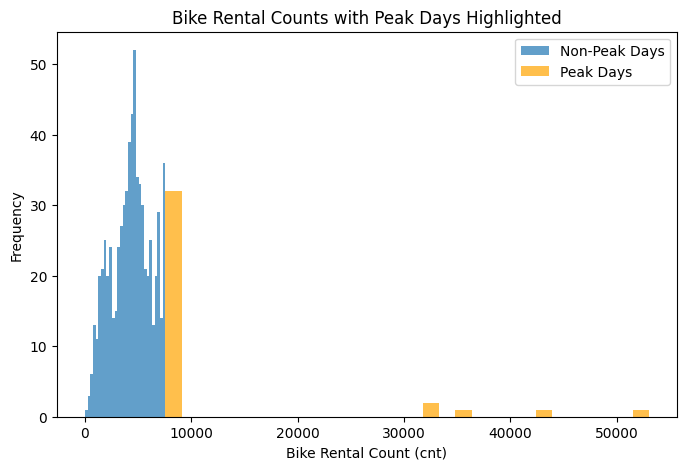

In [40]:
#Show histogram of cnt with peak days highlighted
plt.figure(figsize=(8, 5))
plt.hist(df.loc[~df['is_peak'], 'cnt'], bins=30, alpha=0.7, label='Non-Peak Days')
plt.hist(df.loc[df['is_peak'], 'cnt'], bins=30, alpha=0.7, label='Peak Days', color='orange')
plt.title("Bike Rental Counts with Peak Days Highlighted")
plt.xlabel("Bike Rental Count (cnt)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [41]:
df.groupby('is_peak')['leaflets'].mean()

is_peak
False    739.896403
True     777.081081
Name: leaflets, dtype: float64

In [42]:
df.groupby('is_peak')['price reduction'].mean()


is_peak
False    0.148201
True     0.243243
Name: price reduction, dtype: float64

In [43]:
df.groupby('season')['is_peak'].mean().sort_values(ascending=False)


season
3.0    0.101064
4.0    0.050279
2.0    0.043478
1.0    0.005525
Name: is_peak, dtype: float64

In [44]:
df['is_weekend'] = df['weekday'].isin([5, 6])

df.groupby('is_weekend')['is_peak'].mean()


is_weekend
False    0.034615
True     0.089623
Name: is_peak, dtype: float64

In [45]:
df.groupby('holiday')['is_peak'].mean()

holiday
0    0.052039
1    0.000000
Name: is_peak, dtype: float64

In [46]:
df.groupby('is_peak')[['casual', 'registered']].mean()

,casual,registered
is_peak,,
False,795.094964,3527.351079
True,5997.918919,6071.432432


In [47]:
peak_summary = df.groupby('is_peak').agg({
    'cnt': 'mean',
    'casual': 'mean',
    'registered': 'mean',
    'leaflets': 'mean',
    'price reduction': 'mean',
    'holiday': 'mean',
    'is_weekend': 'mean'
})

print(peak_summary)


                  cnt       casual   registered    leaflets  price reduction  \
is_peak                                                                        
False     4322.446043   795.094964  3527.351079  739.896403         0.148201   
True     12069.351351  5997.918919  6071.432432  777.081081         0.243243   

          holiday  is_weekend  
is_peak                        
False    0.030216    0.277698  
True     0.000000    0.513514  


In [48]:
# Define peak indicator
df['is_peak'] = (df['cnt'] >= df['cnt'].quantile(0.95)).astype(int)

# Select relevant features
features_for_corr = [
    'is_peak',
    'temp',
    'hum',
    'windspeed',
    'weathersit',
    'leaflets',
    'price reduction',
    'holiday',
    'is_weekend',
    'yr'
]

corr_matrix = df[features_for_corr].corr()

# Show only correlations with is_peak
peak_corr = corr_matrix['is_peak'].sort_values(ascending=False)

print(peak_corr)


is_peak            1.000000
yr                 0.230732
temp               0.150714
is_weekend         0.113893
price reduction    0.057837
leaflets           0.048821
holiday           -0.039654
hum               -0.062626
windspeed         -0.095910
weathersit        -0.122044
Name: is_peak, dtype: float64


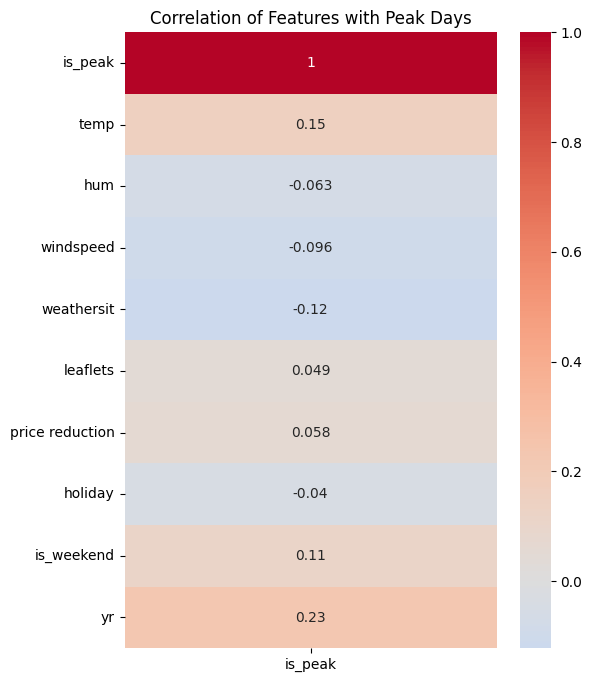

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 8))
sns.heatmap(
    corr_matrix[['is_peak']],
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title("Correlation of Features with Peak Days")
plt.show()


In [53]:
# Create CSV of cleaned test and train data
train_cleaned = df[df['split'] == 'train']
test_cleaned  = df[df['split'] == 'test']
train_cleaned.to_csv('train_cleaned.csv', index=False)
test_cleaned.to_csv('test_cleaned.csv', index=False)


# Save cleaned CSV files in the same folder as the original data
train_cleaned.to_csv(os.path.join(DATA_DIR, 'train_cleaned.csv'), index=False)
test_cleaned.to_csv(os.path.join(DATA_DIR, 'test_cleaned.csv'), index=False)    
